In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
batch_size = 32
img_height = 256
img_width = 256

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "C:\Bottle",
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 428 files belonging to 2 classes.
Using 300 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "C:\Bottle",
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 428 files belonging to 2 classes.
Using 128 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['fail', 'pass']


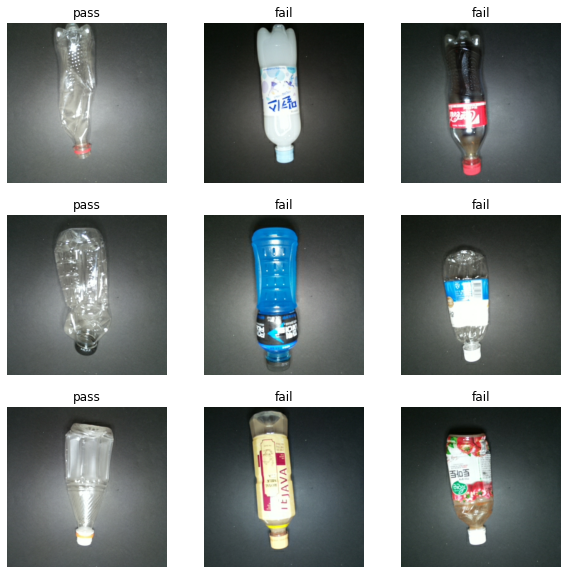

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.098039225 1.0


In [11]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

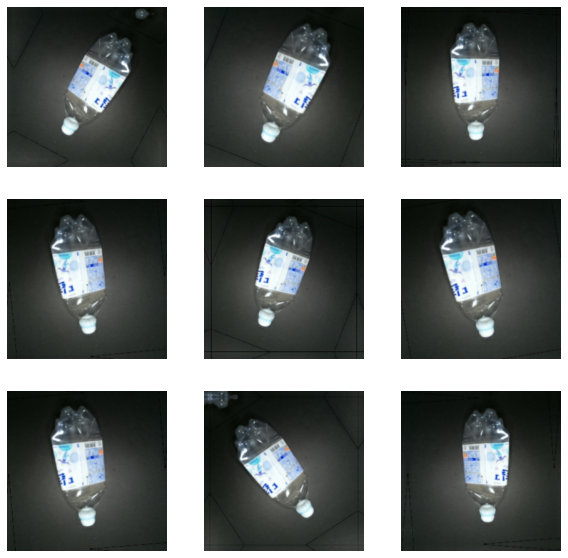

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
num_classes = 2

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

In [16]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
10/10 [==============================] - 14s 1s/step - loss: 1.5294 - accuracy: 0.5900 - val_loss: 0.6126 - val_accuracy: 0.9141
Epoch 2/25
10/10 [==============================] - 13s 1s/step - loss: 0.6162 - accuracy: 0.7267 - val_loss: 0.4272 - val_accuracy: 0.7812
Epoch 3/25
10/10 [==============================] - 13s 1s/step - loss: 0.3798 - accuracy: 0.8367 - val_loss: 0.2627 - val_accuracy: 0.8984
Epoch 4/25
10/10 [==============================] - 13s 1s/step - loss: 0.2267 - accuracy: 0.9133 - val_loss: 0.1159 - val_accuracy: 0.9766
Epoch 5/25
10/10 [==============================] - 13s 1s/step - loss: 0.1423 - accuracy: 0.9467 - val_loss: 0.1171 - val_accuracy: 0.9297
Epoch 6/25
10/10 [==============================] - 13s 1s/step - loss: 0.1246 - accuracy: 0.9500 - val_loss: 0.0677 - val_accuracy: 0.9922
Epoch 7/25
10/10 [==============================] - 13s 1s/step - loss: 0.0972 - accuracy: 0.9733 - val_loss: 0.0550 - val_accuracy: 0.9922
Epoch 8/25
10/10 [==

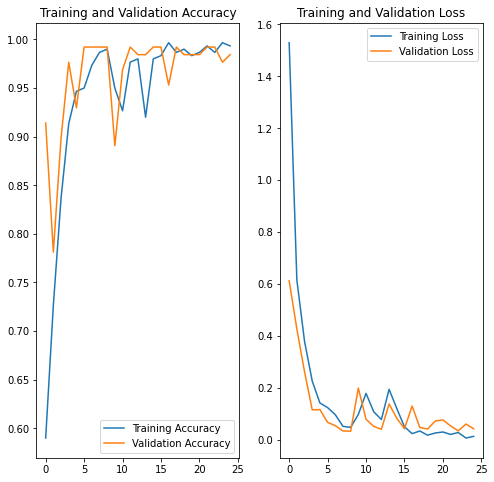

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
img_dir = "C:\Test\Test7.jpg" # Enter Directory of all images  
# from PIL import Image

# image = Image.open('C:\Test\Test4.jpg')
# image.show()
img = keras.preprocessing.image.load_img(
    img_dir, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to pass with a 99.95 percent confidence.


In [27]:
model.save('saved_model/my_modelBest') 

INFO:tensorflow:Assets written to: saved_model/my_modelBest\assets


In [19]:
new_model = tf.keras.models.load_model('saved_model/my_modelBest')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

In [31]:
img_dir = "C:\Test\Test6.jpg" # Enter Directory of all images  
img = keras.preprocessing.image.load_img(
    img_dir, target_size=(img_height, img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to pass with a 99.94 percent confidence.
